In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array, load_img
import random


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [3]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model

In [4]:
DATA_DIR = '/content/drive/MyDrive/parkinsons_dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'Train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'Validation')

In [5]:
IMG_SIZE = 64
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['Normal', 'Parkinson']


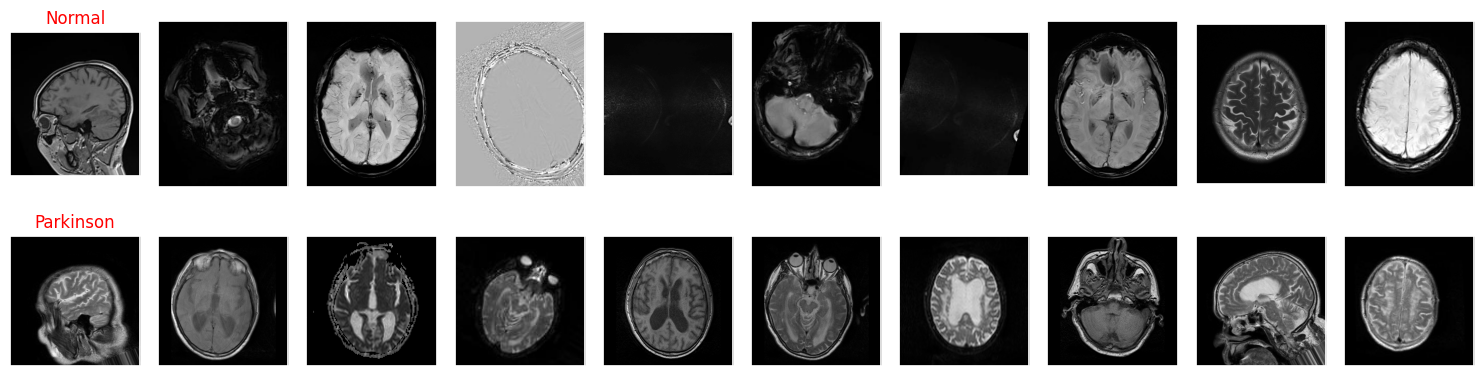

In [42]:
plt.figure(figsize=(15, 20), facecolor='white')
i = 1
for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    random.shuffle(image_list)
    image_list = image_list[:10]
    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array
        plt.subplot(10, 10, i)
        plt.imshow(white_background)
        if i % 10 == 1:
            plt.title(c, color='red')
        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

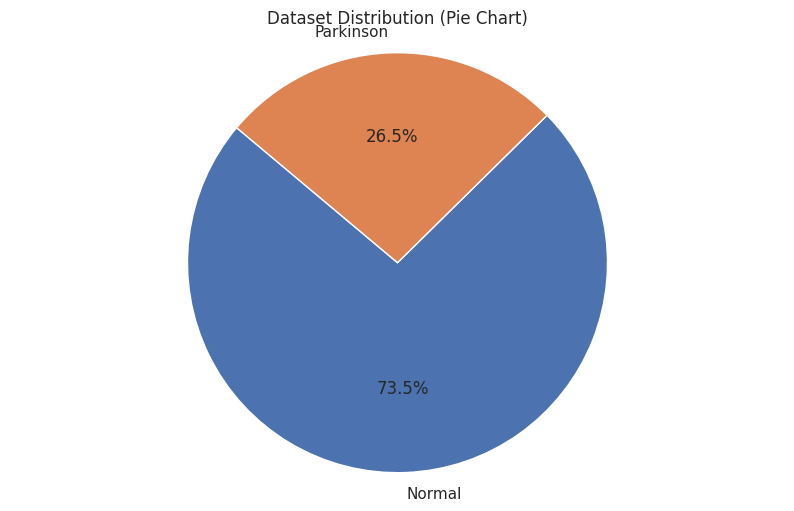

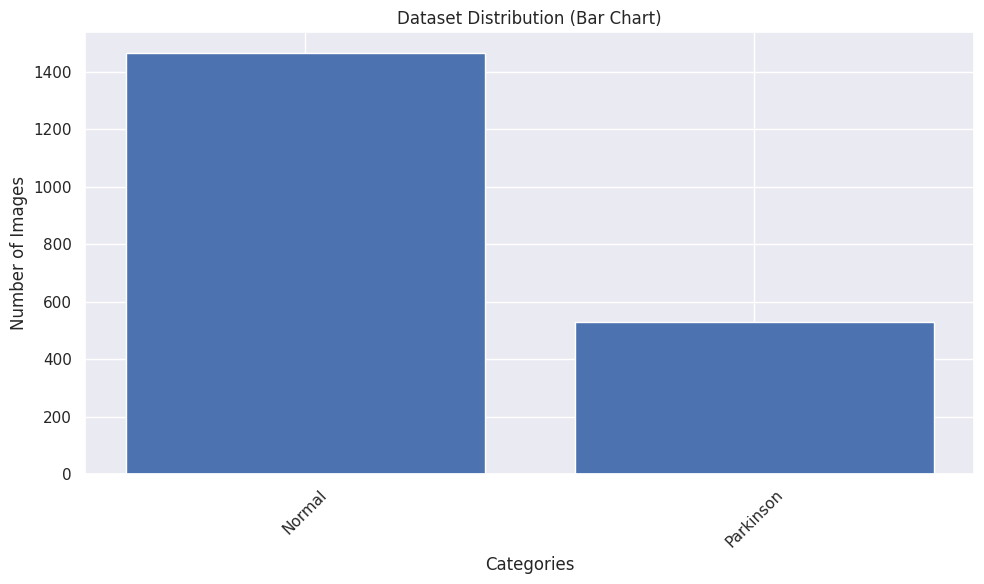

In [43]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 528/528 [00:10<00:00, 50.60it/s] 

1992


In [7]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 132/132 [00:02<00:00, 56.53it/s] 

498


In [8]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (1992, 64, 64, 3) Y_train= (1992,)


In [9]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (498, 64, 64, 3) Y_test= (498,)


Basic CNN

In [10]:
bcnn_model = Sequential()
bcnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(64, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(128, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Flatten())
bcnn_model.add(Dense(128, activation='relu'))
bcnn_model.add(Dropout(0.5))
bcnn_model.add(Dense(len(CATEGORIES), activation='softmax'))

In [11]:
bcnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bcnn = bcnn_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
32/32 [==============================] - 14s 25ms/step - loss: 0.4202 - accuracy: 0.8057 - val_loss: 0.3927 - val_accuracy: 0.8313
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.1919 - accuracy: 0.9332 - val_loss: 0.2399 - val_accuracy: 0.9116
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0861 - accuracy: 0.9734 - val_loss: 0.4150 - val_accuracy: 0.8253
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0676 - accuracy: 0.9789 - val_loss: 0.1354 - val_accuracy: 0.9378
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0322 - accuracy: 0.9910 - val_loss: 0.1816 - val_accuracy: 0.9317
Epoch 6/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0282 - accuracy: 0.9900 - val_loss: 0.0818 - val_accuracy: 0.9659
Epoch 7/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0265 - accuracy: 0.9930 - val_loss: 0.1310 - val_accuracy: 0.9618
Epoch

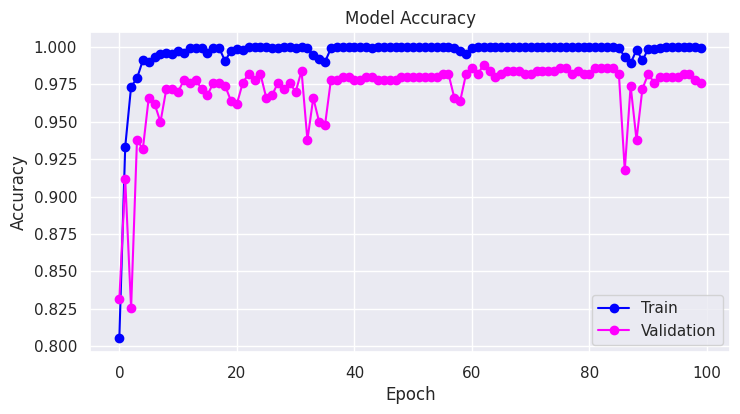

In [12]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['accuracy'], 'o-',color="blue")
plt.plot(bcnn.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

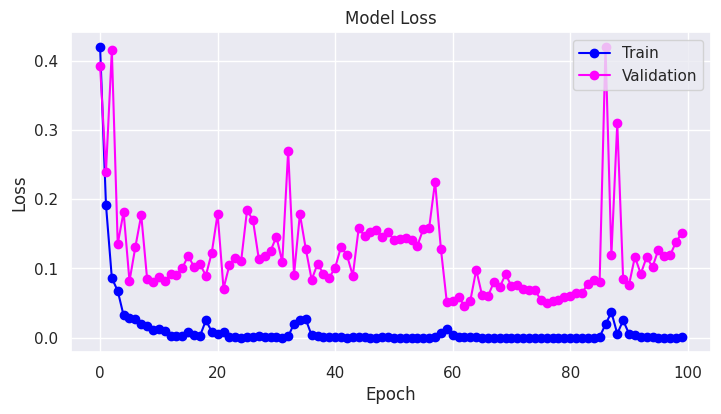

In [13]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['loss'],'o-', color="blue")
plt.plot(bcnn.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [14]:
test_loss, test_acc = bcnn_model.evaluate(X_test, Y_test)
train_loss, train_acc=bcnn_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

63/63 [==============================] - 0s 4ms/step - loss: 2.5534e-05 - accuracy: 1.0000

Test Accuracy: 0.9759036302566528

Test Loss: 0.15146149694919586

Train Accuracy: 1.0

Train Loss: 2.55343402386643e-05


In [15]:
score = bcnn_model.evaluate(X_test,Y_test,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  97.59 %


In [16]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(bcnn_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

16/16 [==============================] - 0s 3ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [17]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[356,  10],
       [  2, 130]])

In [18]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

      Normal      0.994     0.973     0.983       366
   Parkinson      0.929     0.985     0.956       132

    accuracy                          0.976       498
   macro avg      0.961     0.979     0.970       498
weighted avg      0.977     0.976     0.976       498



In [36]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Normal', 'Parkinson'] , columns = ['Normal', 'Parkinson'])

<Axes: title={'center': 'Confusion Matrix'}>

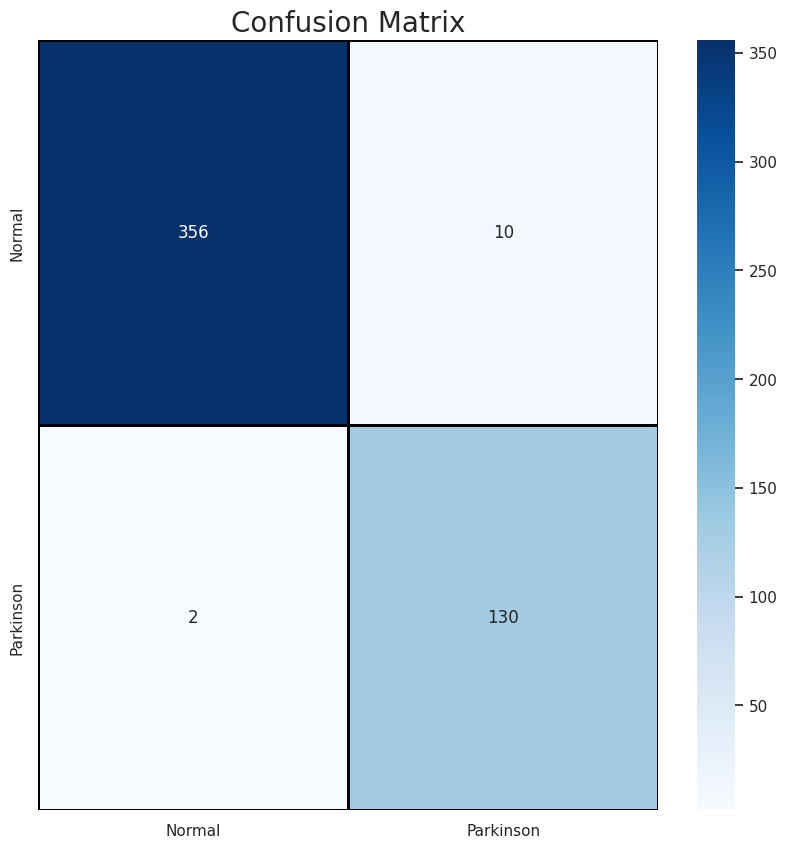

In [20]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

16/16 [==============================] - 0s 3ms/step


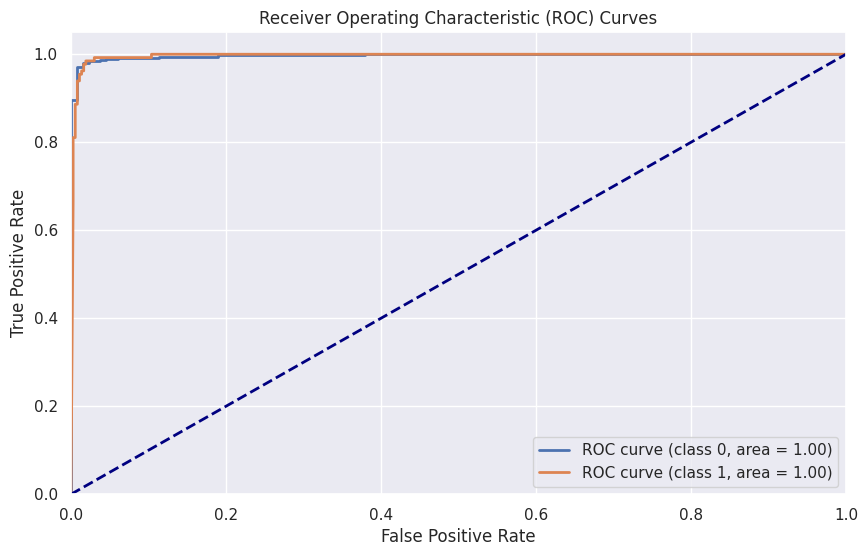

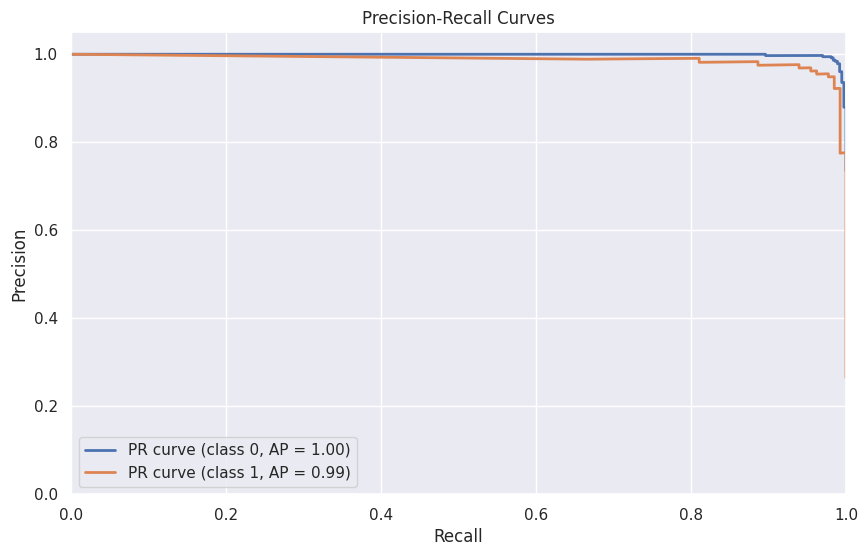

In [21]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = bcnn_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

Modified **CNN**

In [22]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=(64,64,3)),

    ## hidden layer
    layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'), # input->(32,32) output->(28,28)
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    #layers.BatchNormalization(),

    #layers.Dense(64, activation='relu'),
    #layers.BatchNormalization(),

    #layers.Dense(64, activation='relu'),
    #layers.BatchNormalization(),

    ## output layer
    layers.Dense(2, activation='softmax')
])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 batch_normalization (Batch  (None, 60, 60, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                      

In [23]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
#@title Default title text
h = model.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=60)

Epoch 1/100
34/34 [==============================] - 3s 25ms/step - loss: 0.1623 - accuracy: 0.9352 - val_loss: 0.5330 - val_accuracy: 0.7691
Epoch 2/100
34/34 [==============================] - 0s 12ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.6654 - val_accuracy: 0.7349
Epoch 3/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.9591 - val_accuracy: 0.7349
Epoch 4/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0282 - accuracy: 0.9874 - val_loss: 0.8734 - val_accuracy: 0.7349
Epoch 5/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0090 - accuracy: 0.9960 - val_loss: 1.5088 - val_accuracy: 0.7349
Epoch 6/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0095 - accuracy: 0.9960 - val_loss: 1.8320 - val_accuracy: 0.7349
Epoch 7/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0189 - accuracy: 0.9945 - val_loss: 2.1706 - val_accuracy: 0.7349
Epoch 

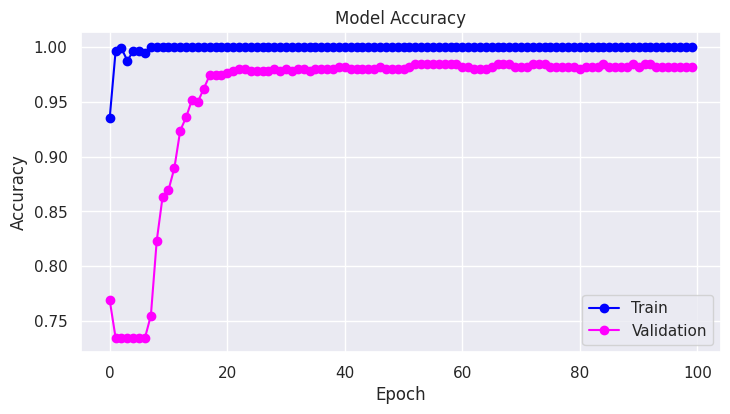

In [25]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(h.history['accuracy'], 'o-',color="blue")
plt.plot(h.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

#plt.close()



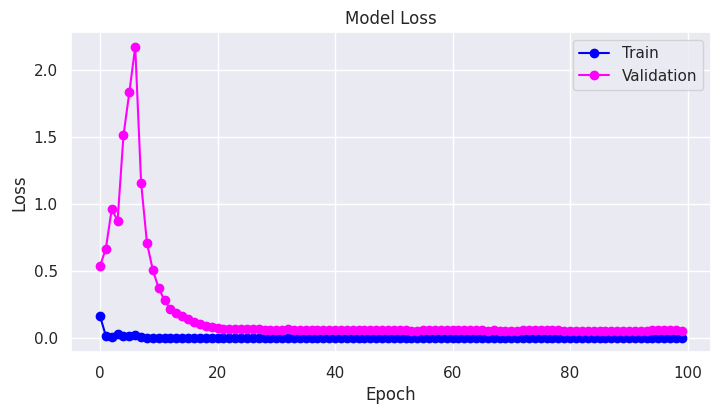

In [26]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(h.history['loss'],'o-', color="blue")
plt.plot(h.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])



In [27]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
train_loss, train_acc=model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

63/63 [==============================] - 0s 5ms/step - loss: 1.3556e-06 - accuracy: 1.0000

Test Accuracy: 0.9819276928901672

Test Loss: 0.053427547216415405

Train Accuracy: 1.0

Train Loss: 1.3555639952755882e-06


In [28]:
score = model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  98.193 %


In [29]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)


16/16 [==============================] - 0s 3ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [30]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[360,   6],
       [  3, 129]])

In [41]:
print(classification_report(Y_test, y_pred,  digits=1,target_names = ['Normal', 'Parkinson']))

              precision    recall  f1-score   support

      Normal        1.0       1.0       1.0       366
   Parkinson        1.0       1.0       1.0       132

    accuracy                            1.0       498
   macro avg        1.0       1.0       1.0       498
weighted avg        1.0       1.0       1.0       498



In [32]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Normal', 'Stroke'] , columns = ['Normal', 'Stroke'])

<Axes: title={'center': 'Confusion Matrix'}>

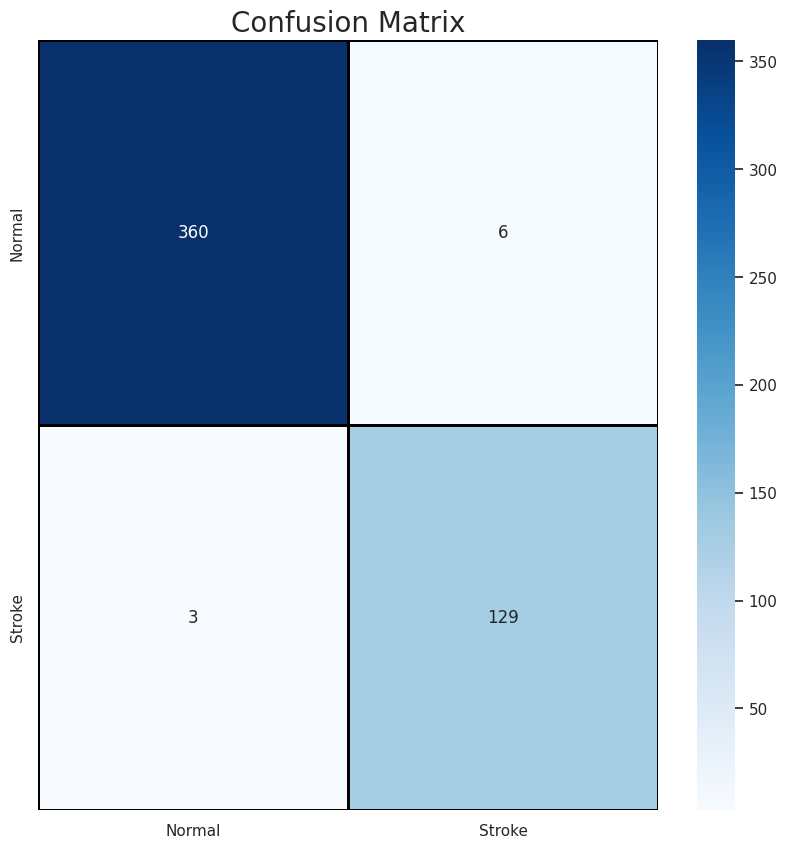

In [33]:
plt.figure(figsize = (10,10))
ct= ['Normal', 'Stroke']
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)


16/16 [==============================] - 0s 3ms/step


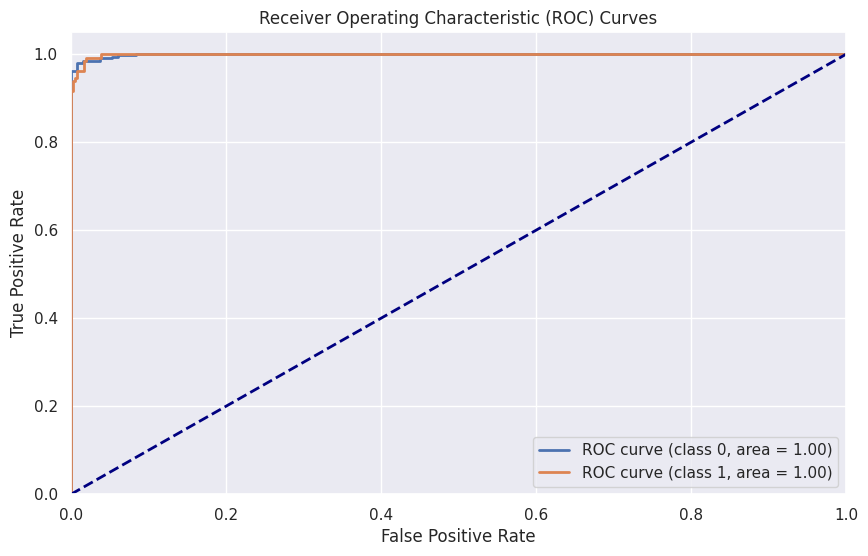

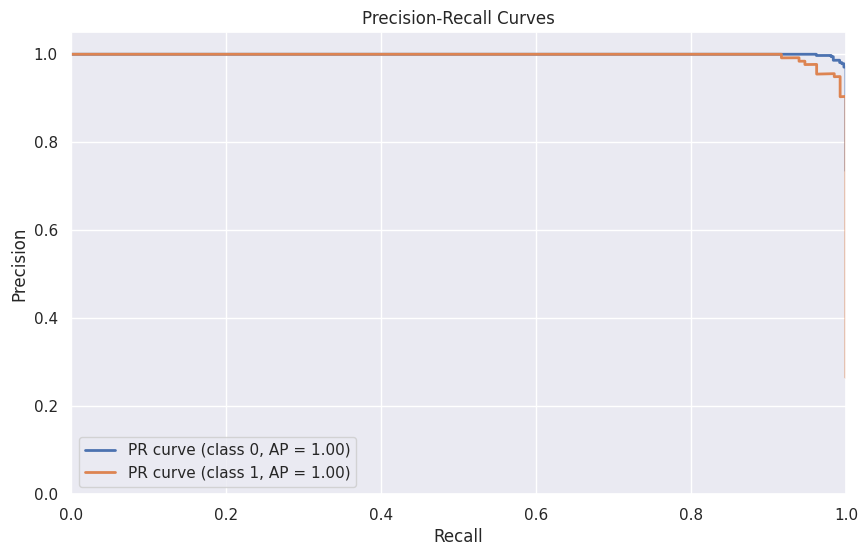

In [57]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = model.predict(X_test)

n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### ALEXNET

In [58]:
from tensorflow import keras
from tensorflow.keras import layers
alexnet_model = keras.Sequential([
    ## input layer
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='valid'),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(units=64),
    layers.Activation('relu'),

    layers.Dense(units=128),
    layers.Activation('relu'),

    layers.Dense(units=64),
    layers.Activation('relu'),

    layers.Dense(units=10),
    layers.Activation('relu'),

    layers.Dense(len(CATEGORIES)),
    layers.Activation('softmax')
])

In [59]:
alexnet_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
alexnet = alexnet_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
32/32 [==============================] - 3s 21ms/step - loss: 0.5375 - accuracy: 0.7354 - val_loss: 0.5415 - val_accuracy: 0.7189
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.3870 - accuracy: 0.8117 - val_loss: 0.5978 - val_accuracy: 0.6165
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.3124 - accuracy: 0.8735 - val_loss: 0.4829 - val_accuracy: 0.7651
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.2242 - accuracy: 0.9172 - val_loss: 0.2517 - val_accuracy: 0.9096
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.1610 - accuracy: 0.9367 - val_loss: 0.1728 - val_accuracy: 0.9478
Epoch 6/100
32/32 [==============================] - 1s 16ms/step - loss: 0.1040 - accuracy: 0.9598 - val_loss: 0.1681 - val_accuracy: 0.9297
Epoch 7/100
32/32 [==============================] - 1s 16ms/step - loss: 0.1356 - accuracy: 0.9513 - val_loss: 0.1811 - val_accuracy: 0.9297
Epoch 

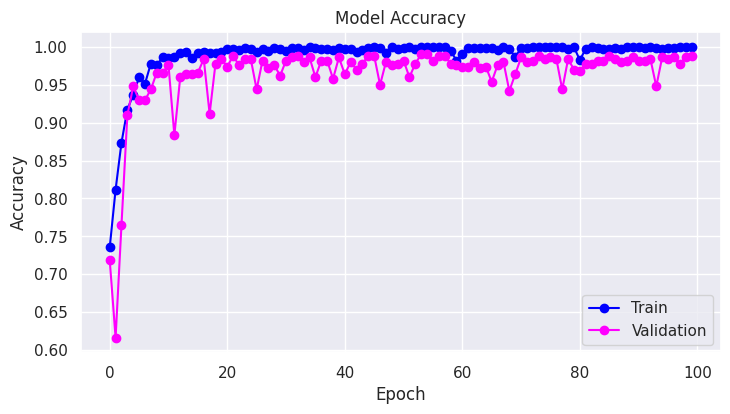

In [60]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(alexnet.history['accuracy'], 'o-',color="blue")
plt.plot(alexnet.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

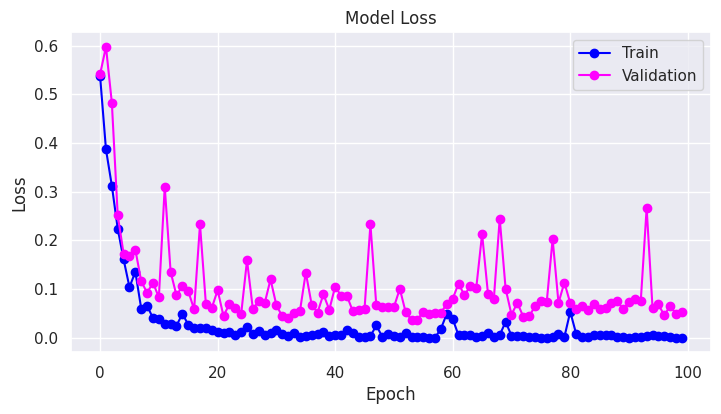

In [61]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(alexnet.history['loss'],'o-', color="blue")
plt.plot(alexnet.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])


In [62]:
test_loss, test_acc = alexnet_model.evaluate(X_test, Y_test)
train_loss, train_acc=alexnet_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

63/63 [==============================] - 0s 3ms/step - loss: 1.6934e-05 - accuracy: 1.0000

Test Accuracy: 0.9879518151283264

Test Loss: 0.05293644592165947

Train Accuracy: 1.0

Train Loss: 1.693405647529289e-05


In [63]:
score = alexnet_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  98.795 %


In [64]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(alexnet_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

16/16 [==============================] - 0s 2ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [65]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[363,   3],
       [  3, 129]])

In [66]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

      Normal      0.992     0.992     0.992       366
   Parkinson      0.977     0.977     0.977       132

    accuracy                          0.988       498
   macro avg      0.985     0.985     0.985       498
weighted avg      0.988     0.988     0.988       498



In [67]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Normal', 'Parkinson'] , columns = ['Normal', 'Parkinson'])

<Axes: title={'center': 'Confusion Matrix'}>

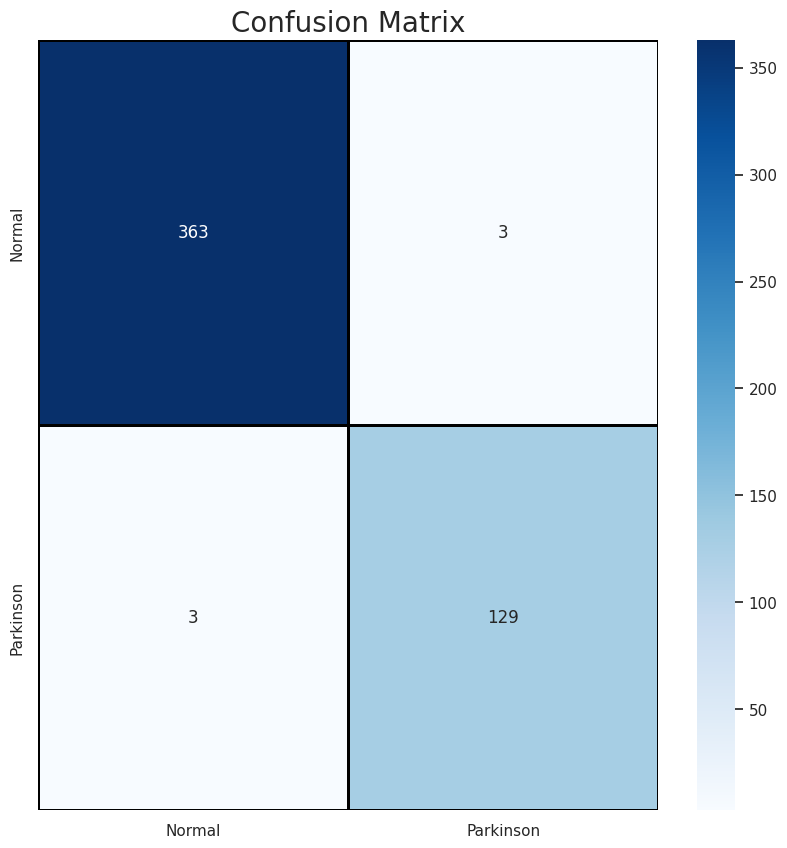

In [68]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

16/16 [==============================] - 0s 4ms/step


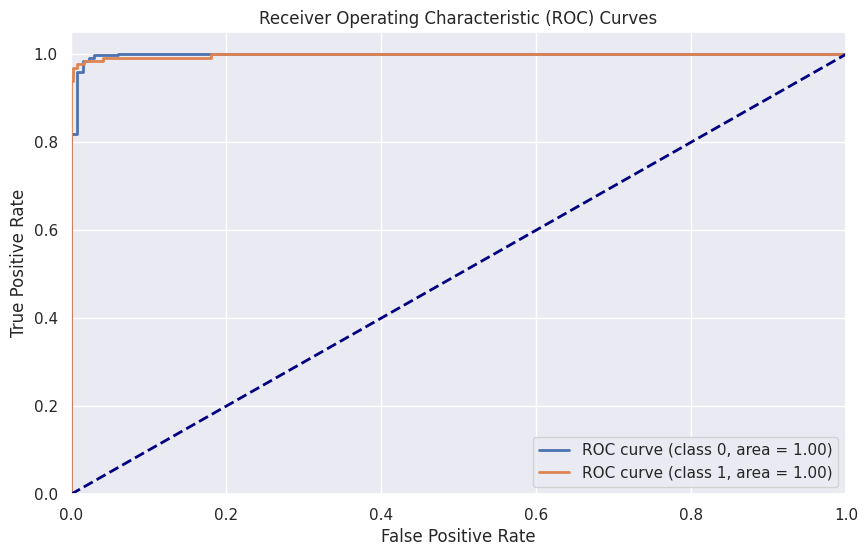

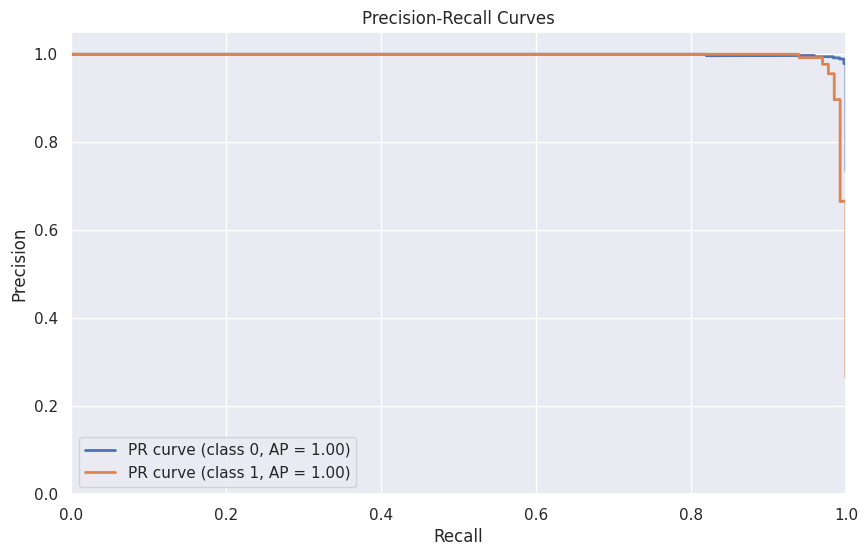

In [69]:
# Calculate ROC and PR curves for each class
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = alexnet_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()